In [2]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import LinearNDInterpolator

In [10]:
def count_nonzero_until_zero(matrix):
    """Returns the number of grid points with a nonzero input, counted for each row from the lowest index until the first zero input.

    Args:
        matrix (np.array): a matrix

    Returns:
        result: number of grid points for each row before a zero input (-1 if no zeros in the entire row)
    """
    
    matrix = np.column_stack((matrix, np.zeros(matrix.shape[0])))
    
    indices = np.argmax(matrix == 0, axis=1)
    
    mask = (indices == matrix.shape[1]-1)
    
    indices[mask] = -1
    
    return indices

def generate_perpendicular_grids(xgr, zgr, resolution=30, max_depth=3):
    """This function takes an xgrid and a zgrid, as well as a resolution and maximum depth, and returns a (temperature) grid perpendicular to the existing x and z-grid.
    ----------
    xgr: array
        1D array of x-values
    zgr: array
        1D array of z-values
    resolution: integer (default: 30)
        number of desired grid points in the 1D models
    max_depth: float (default: 3)
        maximum depth to be modelled
    ---------Returns----------
    Returns: x_matrix, z_matrix
    
    x_matrix: array
        2D array of x-values. Each row contains the x-values for a 1D model
    z_matrix: array
        2D array of z-values. Each row contains the z-values for a 1D model
    """
    temp_depth_grid = np.linspace(0, max_depth, resolution)
    initial_temp = np.linspace(-5, 5, resolution)

    thermal_matrix = np.zeros((xgr.shape[0], temp_depth_grid.shape[0]))

    for i in range(len(thermal_matrix)):
        thermal_matrix[i,:] = initial_temp
        
    gradient = np.gradient(zgr, xgr)

    orientation = np.arctan(gradient) - 0.5 * np.pi
        
    x_matrix = np.tile(xgr, (len(temp_depth_grid), 1)).T + np.outer(np.cos(orientation), temp_depth_grid)
    z_matrix = np.tile(zgr, (len(temp_depth_grid), 1)).T + np.outer(np.sin(orientation), temp_depth_grid)
    
    return x_matrix, z_matrix

In [42]:
def find_thaw_depth(xgr, zgr, temp_matrix, resolution=30, max_depth=3, T_melt=0):
        """Finds thaw depth based on the z-values of the two nearest thaw points."""
        # initialize thaw depth array
        thaw_depth = np.zeros(xgr.shape)

        # get the points from the temperature models
        x_matrix, z_matrix = generate_perpendicular_grids(
            xgr, zgr, 
            resolution=resolution, 
            max_depth=max_depth)
        
        # determine indices of thaw depth in perpendicular model
        indices = count_nonzero_until_zero((temp_matrix > T_melt))

        # find associated coordinates of these points
        x_thaw = x_matrix[np.arange(x_matrix.shape[0]),indices]
        z_thaw = z_matrix[np.arange(x_matrix.shape[0]),indices]
        
        # sort 
        sort_indices = np.argsort(x_thaw)
        x_thaw_sorted = x_thaw[sort_indices]
        z_thaw_sorted = z_thaw[sort_indices]
        
        # loop through the grid        
        for i, x, z in zip(np.arange(len(xgr)), xgr, zgr):
            # try to find two points between which to interpolate for the thaw depth, otherwise set thaw depth to 0
            try:
                mask1 = np.nonzero((x_thaw_sorted < x))
                x1 = x_thaw_sorted[mask1][-1]
                z1 = z_thaw_sorted[mask1][-1]
                
                mask2 = np.nonzero((x_thaw_sorted > x))
                x2 = x_thaw_sorted[mask2][0]
                z2 = z_thaw_sorted[mask2][0]
                
                z_thaw_interpolated = z1 + (z2 - z1)/(x2 - x1) * (x - x1)
                
                thaw_depth[i] = z - (z_thaw_interpolated)
            except:
                thaw_depth[i] = 0
        
        return thaw_depth

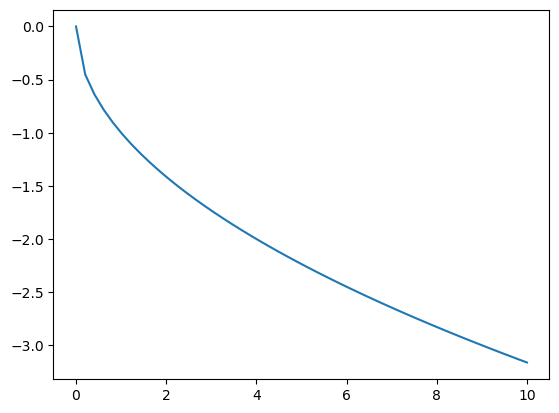

In [43]:
xgr = np.linspace(0, 10)
zgr = -np.sqrt(xgr)

plt.plot(xgr, zgr)

In [44]:
temp_matrix = np.tile(np.linspace(5, -5, 30), (len(xgr), 1))

print(temp_matrix)

[[ 5.          4.65517241  4.31034483 ... -4.31034483 -4.65517241
  -5.        ]
 [ 5.          4.65517241  4.31034483 ... -4.31034483 -4.65517241
  -5.        ]
 [ 5.          4.65517241  4.31034483 ... -4.31034483 -4.65517241
  -5.        ]
 ...
 [ 5.          4.65517241  4.31034483 ... -4.31034483 -4.65517241
  -5.        ]
 [ 5.          4.65517241  4.31034483 ... -4.31034483 -4.65517241
  -5.        ]
 [ 5.          4.65517241  4.31034483 ... -4.31034483 -4.65517241
  -5.        ]]


[15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15]
[-1.41412093 -1.10355781 -0.56869436 -0.23191291  0.06037327  0.32924271
  0.58368106  0.82841504  1.06623236  1.29890664  1.52763037  1.75324004
  1.97634266  2.19739103  2.41673093  2.63463158  2.85130625  3.06692636
  3.28163149  3.49553664  3.70873752  3.92131452  4.13333573  4.34485928
  4.55593509  4.76660637  4.97691068  5.18688089  5.39654587  5.60593113
  5.81505928  6.02395044  6.23262262  6.44109194  6.64937293  6.85747868
  7.06542106  7.27321084  7.4808578   7.6883709   7.8957583   8.1030275
  8.31018539  8.51723828  8.72419203  8.93105203  9.13782327  9.34451038
  9.55111766  9.7564429 ]
[-0.63883472 -1.28717414 -1.84452866 -2.08447669 -2.2586398  -2.39944665
 -2.51979417 -2.62619336 -2.72240374 -2.81079914 -2.89297847 -2.97007289
 -3.04291419 -3.11213336 -3.17822152 -3.24156927 -3.30249296 -3.36125283
 -3.41806596 -3.47

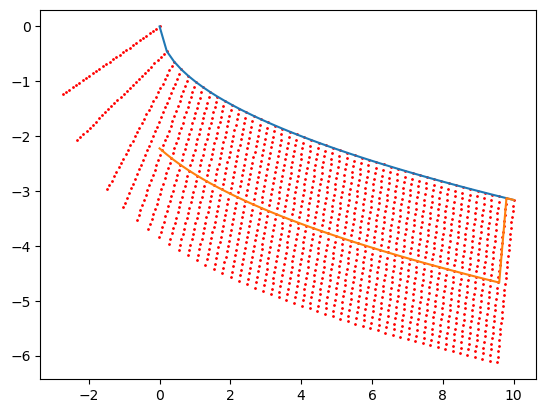

In [48]:
thaw_depth = find_thaw_depth(xgr, zgr, temp_matrix)

x_matrix, z_matrix = generate_perpendicular_grids(xgr, zgr)
abs_xgr = x_matrix.flatten()
abs_zgr = z_matrix.flatten()

plt.plot(xgr, zgr)
plt.plot(xgr, zgr-thaw_depth)
plt.scatter(abs_xgr, abs_zgr, s=1, color='red')

In [51]:
a = np.ones((0, 222))
print(a.shape)

(0, 222)
